# CODECADEMY WALKTHROUGH: LIFE EXPECTANCY & GDP PROJECT
I started the *Data Science* path on [Codecademy](https://www.codecademy.com/catalog/subject/data-science) a few months ago and I am enjoying this new learning experience.\
Now I am facing a new exciting step: posting my work on Medium is the conclusive act for this project.

This walkthrough is the outcome of the *data vizualization portfolio project*, it is available also in the form of *Jupyter notebook* on *github* (link at the end of the story). I keeped the same structure of the notebook so code and descriptions will follow the same cell-like pattern.\
The data given for developing the project are *life expectancy* (in years) and *gross domestic product* (GDP, in dollars) for some countries, taken from the *World Health Organization* (WHO) records.\
For better understanding the meaning of each variable it is suggested to look at Wikipedia's pages for [GDP](https://en.wikipedia.org/wiki/Gross_domestic_product) and [life expectancy](https://en.wikipedia.org/wiki/Life_expectancy).

*Even if data visualization is the scope of this project I added also some statistical tests, another part of the Data Science learning path.*

Before stating the scope of the project it is important to look at the available data.

## Exploratory Data Analysis
Data are provided by *Codecademy* as part of the project in a file named `all_data.csv`.
Before looking at the actual data, relevant packages have to be imported.

### Import Statements

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy.stats import kendalltau
from scipy.stats import ttest_ind

### Load CSV
Now we are ready for loading the csv in `WHO_df` dataframe with `pd.read_csv`.
For an improved readability let's rename the `Life expectancy at birth (years)` to a more friendly `Life_Exp`.\
A column with GDP in trillions ($10^{12}$) is then added to improve readability of GDP values. 

In [2]:
# Read CSV
WHO_df = pd.read_csv('all_data.csv')
# Rename column
WHO_df.rename(columns={'Life expectancy at birth (years)': 'Life_Exp'}, inplace=True)
# Convert GDP to trillions
WHO_df['GDP in trillions'] = ['${:.3f}tn'.format(x/10**12) for x in WHO_df['GDP']]
# Save style for using it every time styling is required
df_format = {'Year': "{:.0f}", 'Life_Exp': "{:.1f}", 'GDP': "{:.3e}"}
df_hidden_col = ['GDP']
df_width = '120px'
# Set table width
pd.options.display.width = 1000
# Print table
display(WHO_df.head(10).style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_properties(width=df_width))

,Country,Year,Life_Exp,GDP in trillions
0,Chile,2000,77.3,$0.078tn
1,Chile,2001,77.3,$0.071tn
2,Chile,2002,77.8,$0.070tn
3,Chile,2003,77.9,$0.076tn
4,Chile,2004,78.0,$0.099tn
5,Chile,2005,78.4,$0.123tn
6,Chile,2006,78.9,$0.155tn
7,Chile,2007,78.9,$0.174tn
8,Chile,2008,79.6,$0.180tn
9,Chile,2009,79.3,$0.172tn


### Descriptive Statistic
We can then look at some descriptive statistical values.

In [3]:
# Available countries
display(WHO_df.Country.value_counts().to_frame().style
        .set_caption('Available countries')
        .set_properties(width=df_width))
# Use pandas describe and then convert GDP to trillions
WHO_df_stats = WHO_df.describe()
WHO_df_stats['GDP in trillions'] = ['${:.3f}tn'.format(x/10**12) for x in WHO_df_stats['GDP']]
# Adjust count to integer for 'GDP in trillions'
WHO_df_stats.loc['count', 'GDP in trillions'] = int(WHO_df_stats.loc['count', 'GDP'])
# Display stats
display(WHO_df_stats.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('Descriptive values')
        .set_properties(width=df_width))

,Country
Mexico,16
Chile,16
Germany,16
China,16
United States of America,16
Zimbabwe,16


,Year,Life_Exp,GDP in trillions
count,96,96.0,96
mean,2008,72.8,$3.880tn
std,5,10.7,$5.198tn
min,2000,44.3,$0.004tn
25%,2004,74.5,$0.173tn
50%,2008,76.8,$1.280tn
75%,2011,78.9,$4.068tn
max,2015,81.0,$18.100tn


There are **six** countries with 16 years of records (from 2000 to 2015).
*Average life expectancy* is 72 year but looking at quartiles it is noticeable that the average value is probably affected by one or more countries with a low *life expectancy*.\
Also *GDP* distribution has at least one country with very low values (see the **min** row), being the interquartile range in between \\$0.173tn and \\$4.068tn.

### Overall View
The first `pairplot` confirms previous statements.

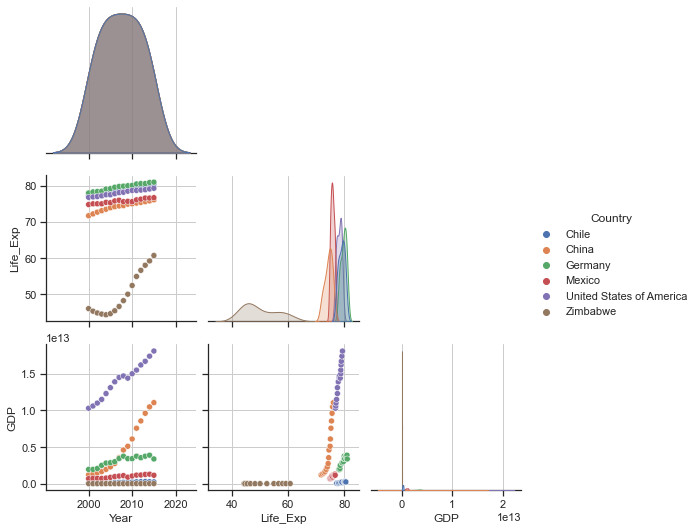

In [4]:
# Theme preferences
sns.set_theme(style='ticks', rc={'axes.grid': True})

# Pairplot
sns.pairplot(WHO_df, hue='Country', corner=True)
plt.show()

A second plot without *Zimbabwe* highlights differences between other nations.

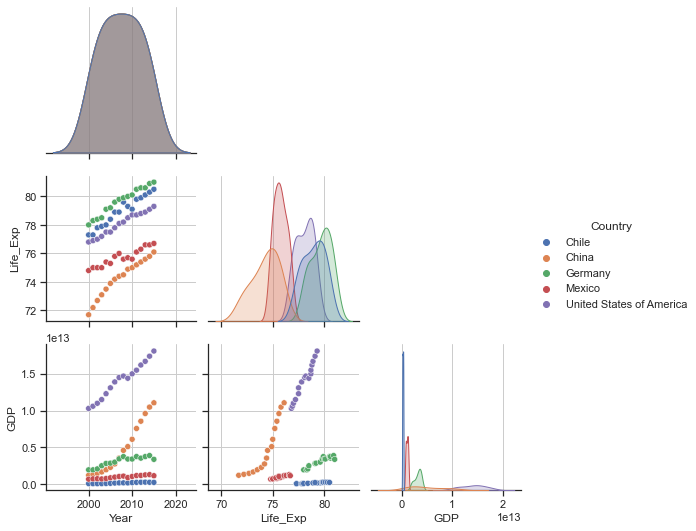

In [5]:
# Pairplot without Zimbabwe
sns.pairplot(WHO_df[WHO_df.Country != 'Zimbabwe'], hue='Country', corner=True)
plt.show()

Looking at variables densities and paired scatterplot it is possible to notice that:
- Zimbawe had a profound crisis which affected GDP and life expectancy (more info [here](https://en.wikipedia.org/wiki/History_of_Zimbabwe)): the way its life expectancy varied is unique in this dataset. There is a downward trend followed by a great improvement.
- America and China show the same positive trend, albeit China's one is delayed by some years of difference.
- Even if Germany has a lower GDP, its life expectancy is better than America and China ones: this fact suggests that a whealthier economy may entail an improved life expectancy, but other factors may have an effect
- Chile is another country with a low GDP but a relatively high life expectancy
- Mexico shows intermediate values both in term of GDP and life expectancy
- It seems that China's economy is flourishing but the healthcare is not at the same level of other nations

It seems that a florid economy improve overall health conditions, but other factors may have an important influence.
Let's compare *Germany and Chile* with *America and China*.\
*Germany* for example developed an efficient national insurance based healthcare system, without the imbalances of the American system. *USA* healthcare is more influenced by economic status: access to better medical cares is easier for wealthy people. The German system has some guarantees to tutelate also people with less financial means (a comparison is available [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3633404/)).\
It is impressive that *Chile* records a better life expectancy than *USA*: it is unlikely that Chile has developed a so much better infrastructure (although [Chilean healthcare](https://en.wikipedia.org/wiki/Healthcare_in_Chile) is historically one of the best in Latin America).\
Probably cultural differences, eating habits, lifestyle, education, etc. concurs with GDP in defining the life expectancy.

## Project Scope
We would like to asses **if there is a correlation between GDP and life expectancy**, and we want to find out how strong this relationship is.\
In addition we would like to know if **life expectancy is statistically different between wealthy countries and the ones with a lower GDP**.

We expect that a correlation is proven, although it may be weaker than we would imagine.\
Statistical significance of *life expectancy* is less predictable since some nations contradict the hypothesis that an higher *GDP* is connected to a better *life expectancy*.

### Correlation between GDP and life expectancy
Since GDP and life expectancy are non-normal, the *Kendall $\tau$* correlation coefficient (`kendalltau`) is used for measuring correlation.\
Normality is tested with `normaltest` from `scipy.stats`.

In [6]:
# Normality test
_, p_val_GDP = normaltest(WHO_df.GDP)
_, p_val_Exp = normaltest(WHO_df.Life_Exp)

Norm_Test = pd.DataFrame({'p_value': [p_val_GDP, p_val_Exp]},index=['GDP', 'Life Expectation'])
alfa = 0.05
Norm_Test['Normality'] = Norm_Test.p_value.apply(lambda x: 'Rejected' if x<alfa else 'Accepted')

display(Norm_Test.style
        .set_caption('Normality test with confidence @ 95%')
        .set_properties(width=df_width))

,p_value,Normality
GDP,0.000007,Rejected
Life Expectation,0.000000,Rejected


After verifying that *GDP* and *life expectation* have non-normal distributions, *Kendall $\tau$* is evaluated.

In [7]:
# Kendall Tau
corr, p_val = kendalltau(WHO_df.GDP, WHO_df.Life_Exp)
print(f'KENDALL TAU: {corr:.3f}\np-value: {p_val:.3e}')

KENDALL TAU: 0.370
p-value: 9.925e-08


The *Kendall $\tau$* highlights a *correlation* between the two variables.\
Values of $\tau$ close to 1 mean strong agreement, while values close to -1 indicate strong disagreement.\
A **moderate agreement** is thus found **between `GDP` and `Life_Exp`**: the following scatter plot agree with this conclusion.

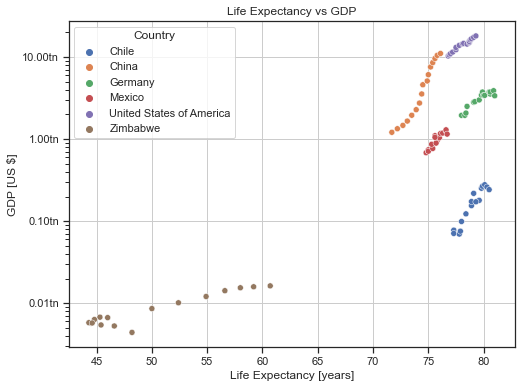

In [8]:
# Scatter plot
plt.figure(figsize=[8, 6])
sns.scatterplot(data=WHO_df, y='GDP', x='Life_Exp', hue='Country')
plt.yscale('log')
plt.title('Life Expectancy vs GDP')
plt.xlabel('Life Expectancy [years]')
plt.ylabel('GDP [US $]')
# Use trillions on y-axis
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}tn'.format(x * 1e-12))

plt.show()

An higher GDP seems connected to a better life expectancy, but this is not the only influencing factor.\
*Chile* has a lower *gross domestic product* compared to *USA* or *China*, nevertheless it shows a good life expectancy.\
*Chile*'s life expectancy is comparable with *Germany*'s one, even if *Chile's GDP is 10 times smaller*.\
This fact strengthen the result of a moderate correlation.

**Note:** *GDP logaritmic scale improve readability, see the visual impact by commenting `plt.yscale('log')` in the previous cell.*

### Hypothesis testing: wealthy countries
Does it exist a statistical evidence that nations with higher GDPs have an higher life expectancy?\
This alternative hypothesis is tested by means of a 2 sample t-test:
- **NULL HYPOTHESIS**: nations with an higher GDP do not have a greater life expectancy
- **ALTERNATIVE HYPOTHESIS**: nations with an higher GDP have a greater life expectancy

This test willl compare the following groups:
- `high_GDP`: United States of America, China, Germany
- `low_GDP`: Mexico, Chile

*Zimbabwe* is not included in the `low_GDP` group because its economy and healthcare are affected by the outcome of a recent *civil war*. This condition is not comparable with other nations from the provided dataset.\
Adding this country to the `low_GDP` group would probably *bias* the result of the test towards wealthy nations: [the previous paragraph](#Correlation-between-GDP-and-life-expectancy) analyzed the whole dataset, now we want to focus on countries with similar *external* conditions, in order to have a meaningful comparison.

16 years are enough for laws to take effect and changing, at least partially, some social systems of a nation.
In order to avoid time-related effects, we focus on recent times: only data from 2015 are considered.

In [9]:
# Divide country by GDP groups
high_GDP = ['United States of America', 'China', 'Germany']
low_GDP = ['Mexico', 'Chile']
high_GDP_df = WHO_df[(WHO_df.Country.isin(high_GDP)) & (WHO_df.Year == 2015)].reset_index(drop=True).copy()
low_GDP_df = WHO_df[(WHO_df.Country.isin(low_GDP)) & (WHO_df.Year == 2015)].reset_index(drop=True).copy()

# Convert GDP to trillions
high_GDP_df['GDP in trillions'] = ['${:.1f}tn'.format(x/10**12) for x in high_GDP_df['GDP']]
low_GDP_df['GDP in trillions'] = ['${:.1f}tn'.format(x/10**12) for x in low_GDP_df['GDP']]

# Print tables
display(high_GDP_df.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('High GDP')
        .set_properties(width=df_width))
display(low_GDP_df.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('Low GDP')
        .set_properties(width=df_width))

# Two sample t-test
alfa = 0.05
t_stat, p_val = ttest_ind(high_GDP_df.Life_Exp, low_GDP_df.Life_Exp)
result = ('significant:\nnations with an higher GDP have an higher life expectancy.' 
          if (p_val/2 < alfa) & (t_stat > 0) else 
          'not significant:\nthere is no evidence that nations with an higher GDP have an higher life expectancy.')

print(f'\n2-sample t-test is {result}\n')
print(f'Significance level: {alfa}')
print(f'p-value: {p_val:.2e}')
print(f't-statistic: {t_stat:.2f}')

,Country,Year,Life_Exp,GDP in trillions
0,China,2015,76.1,$11.1tn
1,Germany,2015,81.0,$3.4tn
2,United States of America,2015,79.3,$18.1tn


,Country,Year,Life_Exp,GDP in trillions
0,Chile,2015,80.5,$0.2tn
1,Mexico,2015,76.7,$1.2tn



2-sample t-test is not significant:
there is no evidence that nations with an higher GDP have an higher life expectancy.

Significance level: 0.05
p-value: 9.37e-01
t-statistic: 0.09


The *alternative hypothesis* is *rejected*. The following boxplot confirms this result.

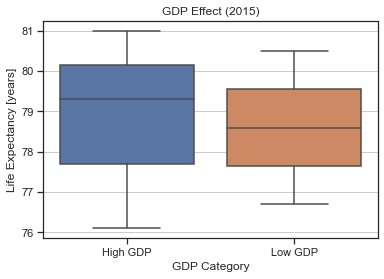

In [10]:
# Aggregate dataframes
wealth_df = pd.concat([high_GDP_df, low_GDP_df])
wealth_df['GDP_Cat'] = None
wealth_df.loc[wealth_df.Country.isin(high_GDP), 'GDP_Cat'] = 'High GDP'
wealth_df.loc[wealth_df.Country.isin(low_GDP), 'GDP_Cat'] = 'Low GDP'

# Boxplot
sns.boxplot(data=wealth_df, x='GDP_Cat', y='Life_Exp')
plt.title('GDP Effect (2015)')
plt.xlabel('GDP Category')
plt.ylabel('Life Expectancy [years]')
plt.show()

The two boxplots are really similar in term of *interquartile range* and median. Whiskers of wealthy countries are more extended than the ones of countries with lower GDP: this is a consequence of *Germany* and *China* life expectancies (which show respectively high and low values).

## Conclusions
The gross domestic product is related to the overall wealth generated by the economy of a country.\
A florid economy attracts investors: the consequent availability of funds may lead to a better healthcare.\
A constant flux of money is not sufficient though, authorities have to set a clear investment strategy for the system to work efficiently. If a nation focus properly its efforts and investments, it could achieve better performances than wealthier nations, in terms of medical cares (e.g. *Germany*).\
In addition other factors can undermine the effectiveness of a good infrastructure (*political stability* or *lifestyle* for example) with the result that unexpected countries can outperform wealthier nations just by exploiting a favourable context (this may be the case of *Chile* showing better results than *USA* in term of *life expectancy*).

**Life expectancy and GDP seems correlated but there is much more to consider when looking at how they relate.**

In fact the hypothesis test resulted in a not-significant difference between two comparable groups of nations (low GDPs vs high GDPs).\
It worth mention that all nations included in *Codecademy* dataset are relatively similar, with *Zimbabwe* being the only exception.\
It is the only African country in our dataframe.

Take a look at the following image (from Wikipedia) with world's GDPs for 2014:

![GDP_Wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/Countries_by_GDP_%28Nominal%29_in_2014.svg/1920px-Countries_by_GDP_%28Nominal%29_in_2014.svg.png)

**Africa has the highest concentrations of countries with really low GDPs** (and Zimbabwe is among them).\
We should have had more countries similar to *Zimbabwe* to have a realistic picture of the relationship between *GDP* and *life expectancy*.
This is the reason why *Zimbabwe* has been removed from the `low_GDP` group in "[Hypothesis testing: wealthy countries](#Hypothesis-testing:-wealthy-countries)".\
We decided to see if a difference existed between countries that are similar from a socio-political point of view, instead than highlighting the (obvious) effect of *Zimbabwe* over the `low_GDP` group (you can try to run the hypothesis test with *Zimbabwe* included in the `low_gdp_df` to see if the result changes).

We have seen that **no evidence of statistical difference exists between the selected groups** in term of *life expectancy*: note that Germany, China, USA, Chile and Mexico are *relatively* similar in term of color in 2014 GDP map, even if the difference in therm of value is meaningful (*German* GDP is twice as high as *Mexican* one).\
We do not know if including nations with an higher gap in GDP may highlight a relevant difference in term of *life expectancy* (like *Zimbabwe* case suggests).

The following violin plot gives an idea of the divide between countries with a *weaker economy* like *Zimbabwe* and the rest of the world.

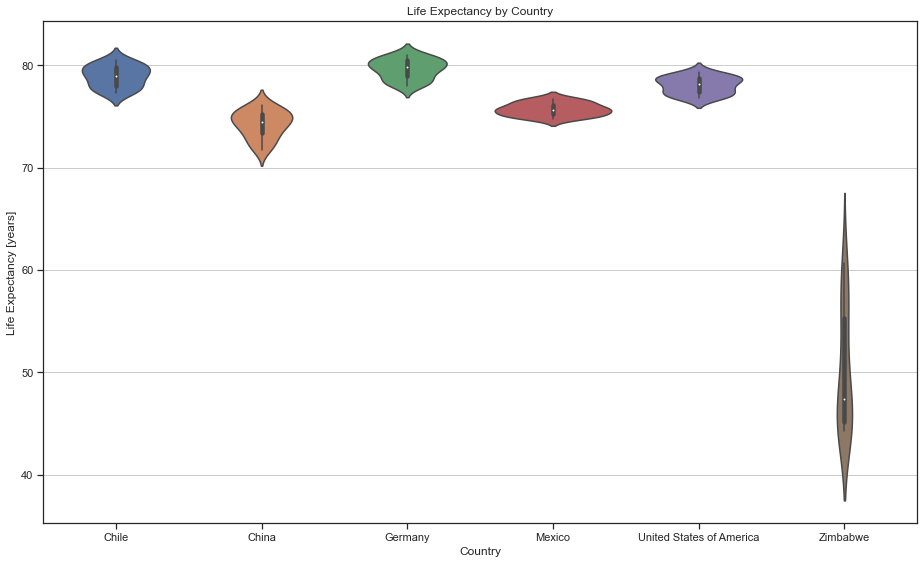

In [11]:
plt.figure(figsize=[13, 8])
sns.violinplot(data=WHO_df, x='Country', y='Life_Exp')
plt.title('Life Expectancy by Country')
plt.ylabel('Life Expectancy [years]')
plt.tight_layout()
plt.show()

To obtain more significative results we should broaden the analysis by including an ample variety of countries, at least by increasing the number of nations which are really different from the *strong economies* that are part of this dataset.